### Setup

In [175]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf
from alpha_vantage.timeseries import TimeSeries
import time
import datetime
import http
import json
import calendar
import os
from datetime import timedelta, date
from typing import Dict, List, Tuple
from http import client
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
%matplotlib inline
sns.set_theme()

from keys import client_id, secret_key, av_key

### Datasets

In [29]:
pd.set_option('display.max_rows', 150)

In [7]:
gme = pd.read_csv('data/STOCK_US_XNYS_GME.csv') # dataset is TINY. NEED MORE DATA
wsb_posts = pd.read_csv('data/reddit_wsb_posts.csv', index_col=0)

In [30]:
wsb_comments = pd.read_csv('data/wsb_comments_raw.csv', 
                           nrows=20000, 
                           error_bad_lines=False) # dataset is HUGE. Restricting to 20,000

In [162]:
vac = pd.read_csv('data/vaccination-data.csv')
vac_meta = pd.read_csv('data/vaccination-metadata.csv')

In [166]:
vac.head(2)

,COUNTRY,ISO3,WHO_REGION,DATA_SOURCE,DATE_UPDATED,TOTAL_VACCINATIONS,PERSONS_VACCINATED_1PLUS_DOSE,TOTAL_VACCINATIONS_PER100,PERSONS_VACCINATED_1PLUS_DOSE_PER100,VACCINES_USED,FIRST_VACCINE_DATE,NUMBER_VACCINES_TYPES_USED
0,Mongolia,MNG,WPRO,REPORTING,2021-03-19,100004.0,98131.0,3.050,2.993,"AstraZeneca - AZD1222,Beijing CNBG - Inactivat...",2021-02-23,5.0
1,French Guiana,GUF,AMRO,REPORTING,2021-03-19,9015.0,6848.0,3.018,2.293,NaN,NaN,NaN


In [167]:
vac_meta.head(2)

,ISO3,VACCINE_NAME,PRODUCT_NAME,COMPANY_NAME,AUTHORIZATION_DATE,START_DATE,END_DATE,COMMENT,DATA_SOURCE
0,CPV,SII - Covishield,Covishield,Serum Institute of India,NaN,2021-03-18,NaN,NaN,REPORTING
1,PER,Wuhan CNBG - Inactivated,Inactivated SARS-CoV-2 vaccine,Wuhan Institute of Biological Products (CNBG),2001-01-26,2021-02-09,NaN,NaN,REPORTING


#### Yahoo Finance

In [93]:
gme_df = yf.download('GME', start='2020-01-01', end='2021-03-28', progress=True)
gme_df['Change'] = gme_df.Close - gme_df.Open
gme_df['Put/Call OI Ratio'] = float(0)

[*********************100%***********************]  1 of 1 completed


In [96]:
gme_df

,Open,High,Low,Close,Adj Close,Volume,Change,Put/Call OI Ratio
Date,,,,,,,,
2020-01-02,6.140000,6.470000,6.070000,6.310000,6.310000,4453600,0.170000,0.0
2020-01-03,6.210000,6.250000,5.840000,5.880000,5.880000,3543900,-0.330000,0.0
2020-01-06,5.800000,5.910000,5.600000,5.850000,5.850000,3394800,0.050000,0.0
2020-01-07,5.770000,5.830000,5.440000,5.520000,5.520000,5228000,-0.250000,0.0
2020-01-08,5.490000,5.850000,5.410000,5.720000,5.720000,5629400,0.230000,0.0
...,...,...,...,...,...,...,...,...
2021-03-22,205.259995,210.360001,186.199997,194.490005,194.490005,10061500,-10.769989,0.0
2021-03-23,197.500000,201.750000,177.550003,181.750000,181.750000,14429100,-15.750000,0.0
2021-03-24,157.979996,166.970001,118.620003,120.339996,120.339996,24177900,-37.639999,0.0


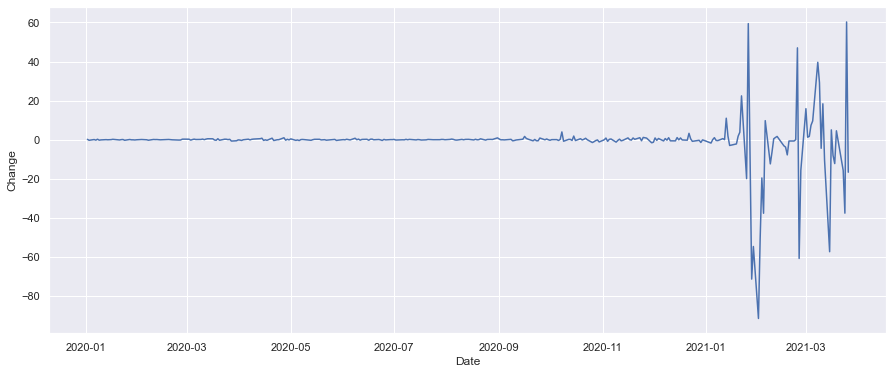

In [177]:
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(x=gme_df.index, y=gme_df['Change']);

#### Alpha Vantage API

In [100]:
ts = TimeSeries(key=av_key, output_format='pandas')
data, meta_data = ts.get_intraday(symbol='GME', interval='1min', outputsize='full')

In [ ]:
TimeSeries()

In [102]:
data

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2021-03-26 20:00:00,178.51,179.00,178.50,178.50,2653.0
2021-03-26 19:59:00,179.01,179.25,179.00,179.00,1845.0
2021-03-26 19:58:00,179.02,179.02,179.02,179.02,384.0
2021-03-26 19:57:00,179.30,179.30,179.01,179.01,910.0
2021-03-26 19:56:00,179.75,179.75,179.40,179.40,795.0
...,...,...,...,...,...
2021-03-15 04:05:00,273.16,274.80,273.00,273.00,3254.0
2021-03-15 04:04:00,271.93,273.00,271.93,272.99,3584.0
2021-03-15 04:03:00,270.16,271.99,270.10,271.99,2736.0


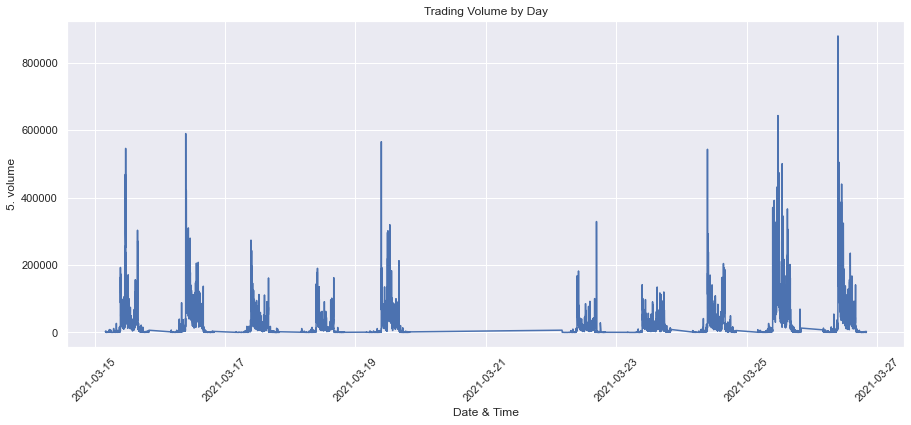

In [183]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Trading Volume by Day')
ax.set_xlabel('Date & Time')
plt.xticks(rotation=45)
sns.lineplot(x=data.index, y=data['5. volume']);

In [103]:
qqq_ts = TimeSeries(key=av_key, output_format='pandas')
qqq_df, qqq_meta = qqq_ts.get_intraday(symbol='QQQ', interval='1min', outputsize='full')

In [104]:
spy_ts = TimeSeries(key=av_key, output_format='pandas')
spy_df, spy_meta = spy_ts.get_intraday(symbol='SPY', interval='1min', outputsize='full')

In [105]:
XRT_ts = TimeSeries(key=av_key, output_format='pandas')
XRT_df, XRT_meta = XRT_ts.get_intraday(symbol='XRT', interval='1min', outputsize='full')

In [106]:
iwm_ts = TimeSeries(key=av_key, output_format='pandas')
iwm_df, iwm_meta = iwm_ts.get_intraday(symbol='IWM', interval='1min', outputsize='full')

In [107]:
dow_ts = TimeSeries(key=av_key, output_format='pandas')
dow_df, dow_meta = dow_ts.get_intraday(symbol='DIA', interval='1min', outputsize='full')

In [108]:
vxx_ts = TimeSeries(key=av_key, output_format='pandas')
vxx_df, vxx_meta = vxx_ts.get_intraday(symbol='VXX', interval='1min', outputsize='full')

In [109]:
dow_df

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2021-03-26 19:59:00,330.5200,330.5200,330.5200,330.5200,1744.0
2021-03-26 19:53:00,330.7600,330.7600,330.6100,330.6100,426.0
2021-03-26 19:44:00,330.5300,330.5300,330.5300,330.5300,412.0
2021-03-26 19:43:00,330.7800,330.7800,330.7800,330.7800,826.0
2021-03-26 19:23:00,330.7700,330.7700,330.7700,330.7700,302.0
...,...,...,...,...,...
2021-03-15 04:22:00,328.6032,328.6032,328.6032,328.6032,210.0
2021-03-15 04:16:00,328.7230,328.7230,328.7230,328.7230,100.0
2021-03-15 04:13:00,328.4935,328.4935,328.4735,328.4735,5710.0


#### Tradier

In [130]:
url = 'https://sandbox.tradier.com/v1/

In [136]:
tradier_token = '69baPKJIfXjZDOGj9Raekni5gTS1'

In [153]:
class Tradier:
    def __init__(self, auth: str, storage_path="data/"):
        self.storage_path = storage_path
        self.connection = http.client.HTTPSConnection(
            "sandbox.tradier.com", 443, timeout=30)
        self.headers = headers = {"Accept": "application/json",
                                  "Authorization": "Bearer {}".format(auth)}
 
    def request(self, endpoint: str):
        self.connection.request("GET", endpoint, None, self.headers)
        try:
            response = self.connection.getresponse()
            content = response.read()
            if int(str(response.status)) == 200:
                return json.loads(bytes.decode(content))
            return None
        except http.HTTPException as e:
            return e
 
    def options(self, symbol: str):
        return Options(self, symbol)
 
    def historical_data(self, symbol: str):
        endpoint = "/v1/markets/history?symbol={}".format(symbol)
        return self.request(endpoint)
 
    def load_data(self, symbol: str) -> pd.DataFrame:
        path = self.storage_path + "{}.csv".format(symbol)
        if os.path.exists(path):
            df = pd.read_csv(path)
            df = df.set_index(pd.DatetimeIndex(df["date"]))
            df = df.loc[:, ~df.columns.str.contains('date')]
            df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
            return df
        else:
            try:
                df = pd.DataFrame(self.historical_data(
                    symbol).get("history", {}).get("day", []))
                df = df.set_index(pd.DatetimeIndex(df["date"]))
                df = df.loc[:, ~df.columns.str.contains('date')]
                df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
                df.to_csv(path)
                return df
            except Exception as e:
                print(e)
                return None
 
 
def third_fridays(d, n):
    """Given a date, calculates n next third fridays
    https://stackoverflow.com/questions/28680896/how-can-i-get-the-3rd-friday-of-a-month-in-python/28681097"""
 
    def next_third_friday(d):
        """ Given a third friday find next third friday"""
        d += timedelta(weeks=4)
        return d if d.day >= 15 else d + timedelta(weeks=1)
 
    # Find closest friday to 15th of month
    s = date(d.year, d.month, 15)
    result = [s + timedelta(days=(calendar.FRIDAY - s.weekday()) % 7)]
 
    # This month's third friday passed. Find next.
    if result[0] < d:
        result[0] = next_third_friday(result[0])
 
    for i in range(n - 1):
        result.append(next_third_friday(result[-1]))
 
    return result
 
class Options:
    def __init__(self, tradier: Tradier, symbol: str):
        self.api = tradier
        self.symbol = symbol
        self.cache = {}
 
    def call(self, expiration: date, strike: int) -> pd.DataFrame:
        chain = "{symbol}{y}{m:02d}{d:02d}C{strike:05d}000".format(symbol=self.symbol, y=str(
            expiration.year)[2:], m=expiration.month, d=expiration.day, strike=strike)
        if chain in self.cache:
            return self.cache[chain]
        else:
            df = self.api.load_data(chain)
            self.cache[chain] = df
            return df
 
    def put(self, expiration: date, strike: int) -> pd.DataFrame:
        chain = "{symbol}{y}{m:02d}{d:02d}P{strike:05d}000".format(symbol=self.symbol, y=str(
            expiration.year)[2:], m=expiration.month, d=expiration.day, strike=strike)
        if chain in self.cache:
            return self.cache[chain]
        else:
            df = self.api.load_data(chain)
            self.cache[chain] = df
            return df
 
#     def load_data(self, symbol: str) -> pd.DataFrame:
#         path = self.storage_path + "{}.csv".format(symbol)
#         if os.path.exists(path):
#             df = pd.read_csv(path)
#             df = df.set_index(pd.DatetimeIndex(df["date"]))
#             df = df.loc[:, ~df.columns.str.contains('date')]
#             df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
#             return df
#         else:
#             try:
#                 df = pd.DataFrame(self.historical_data(
#                     symbol).get("history", {}).get("day", []))
#                 df = df.set_index(pd.DatetimeIndex(df["date"]))
#                 df = df.loc[:, ~df.columns.str.contains('date')]
#                 df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
#                 df.to_csv(path)
#                 return df
#             except Exception as e:
#                 print(e)
#                 return None
    
    def initialize_repository(self):
        ''' 
        Download all of the historical price data for all monthly expirations within a 10%
        price range of the underlying for that month. This can be manually changed in the code 
        below. By default, this downloads data from 2020 only. Beyond that is an exercise for the reader
        '''
 
        # historical price data for the underlying, which we will merge in
        data = self.api.load_data(self.symbol)
 
        # calculate monthly high and low for the underlying
        monthly_range = {}
        for m in range(1, 13):
            try:
                x = data[date(2020, m, 1):date(2020, m + 1, 1)]
                monthly_range[m] = dict(low=min(x['low']), high=max(x['high']))
            except:
                # If we don't have data for this month, just extrapolate from the previous month
                monthly_range[m] = dict(
                    low=monthly_range[m - 1]['low'], high=monthly_range[m - 1]['high'])
 
        for m, k in monthly_range.items():
            expiration = third_fridays(date(2020, m, 1), 1)[0]
            # Get all strikes that are 10% below the monthly low and 10% above the monthly high
            strikes = [x for x in range(int(k['low'] * .9), int(k['high'] * 1.1))]
            # Download and save all of the option chains
            for s in strikes:
                self.call(expiration, s)
                self.put(expiration, s)

In [161]:
api = Options(tradier_token, symbol='GME')
api.initialize_repository()

AttributeError: 'str' object has no attribute 'load_data'

In [142]:
gme_ho = pd.read_csv('data/GME.csv')

In [143]:
gme_ho

,date,open,high,low,close,volume
0,2021-01-04,19.0000,19.1000,17.1500,17.25,10022474
1,2021-01-05,17.3500,18.0765,17.2300,17.37,4961457
2,2021-01-06,17.3400,18.9800,17.3300,18.36,6056248
3,2021-01-07,18.4700,19.4500,18.0200,18.08,6129276
4,2021-01-08,18.1800,18.3000,17.0800,17.69,6481960
5,2021-01-11,19.4100,20.6500,19.0100,19.94,14927612
6,2021-01-12,19.9600,20.4000,19.3168,19.95,7060665
7,2021-01-13,20.4200,38.6500,20.0300,31.40,144501740
8,2021-01-14,38.0900,43.0600,33.0500,39.91,93717410
9,2021-01-15,38.4900,40.7500,34.0100,35.50,46782763


# Cleaning

# EDA

# Feature Engineering

**QQQ** — Nasdaq  
**SPY** — S&P 500  
**XRT** — Retail (GME among these)  
**IWM** — Russel 2000  
**DJIA** — Dow Jones Industrial Average  
**VXX** — Barclay's ETF for VIX CBOE Volatility Index

# Modeling

# TBD

#### CSV Files in `data/`

#### Ticker Function for Alpha Venture

In [ ]:
def fstr(template, **kwargs):
    return eval(f"f'{template}'", kwargs)

df_list = []
unique_ticker = f'{ticker}_df'
df_list.append(unique_ticker)

for ticker in ticker_list:
    print(unique_ticker, element=element))

In [113]:
def ticker_df(ticker_list):
    df_list = []
    for ticker in ticker_list:
        unique_ticker = f'{ticker}_df'
        df_list.append(unique_ticker)
        ts = TimeSeries(key=av_key, output_format='pandas')
        df = ts.get_intraday(symbol=f'{ticker.upper()}',
                                         interval='1min',
                                         outputsize ='full')
        
    print(f'{ticker_list} have been imported to DataFrame as {df_list}')

SyntaxError: invalid syntax (<ipython-input-113-71695b0ae57f>, line 7)

#### Reddit API

#### Pandas DataReader

In [83]:
# start = datetime.datetime(2020, 1, 1)
# end = datetime.datetime.now()
# df = web.DataReader("GME", start, end)
# df.reset_index(inplace=True)
# df.set_index("Date", inplace=True)
# df = df.drop("Symbol", axis=1)

# print(df.head())

NotImplementedError: data_source=datetime.datetime(2020, 1, 1, 0, 0) is not implemented

In [58]:
# wsb_comments[wsb_comments.associated_award != 'NaN']
wsb_comments[wsb_comments.author == 'LazyMeal']

,associated_award,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,author_flair_type,author_fullname,...,subreddit_id,total_awards_received,treatment_tags,top_awarded_type,edited,distinguished,comment_type,author_cakeday,editable,media_metadata
all_awardings,,,,,,,,,,,,,,,,,,,,,
[],NaN,LazyMeal,NaN,NaN,[],NaN,NaN,NaN,text,t2_4yxnnufz,...,t5_2th52,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
[],NaN,LazyMeal,NaN,NaN,[],NaN,NaN,NaN,text,t2_4yxnnufz,...,t5_2th52,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
[],NaN,LazyMeal,NaN,NaN,[],NaN,NaN,NaN,text,t2_4yxnnufz,...,t5_2th52,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
len(gme)

23

NASDAQ GME dataset is ridiculously short. Need to find a better dataset.

In [59]:
wsb_posts.head()

,score,id,url,comms_num,created,body,timestamp
title,,,,,,,
"It's not about the money, it's about sending a message. 🚀💎🙌",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
Math Professor Scott Steiner says the numbers spell DISASTER for Gamestop shorts,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
NEW SEC FILING FOR GME! CAN SOMEONE LESS RETARDED THAN ME PLEASE INTERPRET?,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
"Not to distract from GME, just thought our AMC brothers should be aware of this",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56


#### EOD Historical Options Data

In [131]:
requests.get(url)

<Response [402]>

In [121]:
url = 'https://eodhistoricaldata.com/api/options/GME.US?api_token=60611ad7aea179.31218368'


def api_call(url):
    """
    This function will call the EOD Historical Options Chain API,
    and return the data as a JSON 
    This will use the requests module to get from EOD. 
    """
    response = requests.get(url) # our url, header and params should be consistent, atleast with our Yelp data
    data = response.json()
    return data


In [122]:
api_call(url)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)